### Building a Trading strategy for Alphabet Inc stock by using ARIMA forecasting method

ARIMA model is built for forecasting the Alphabet stock price which if further used for building the trading strategies.

Data: Alphabet Inc Adjusted Close price data for over 16 years is pulled from Yahoo finance website.  

## Load data

In [1]:
#Import libraries
import numpy as np, pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load ALPHABET INC stock csv data and store to a dataframe and convert Date into Datetime format
df=pd.read_csv("D:\\Courses\\Data.csv")  
df= df.rename(columns={'Adj_Close': 'price'})
df['Date'] =  pd.to_datetime(df['Date'])
df.fillna(method='ffill', inplace=True)
df.head()

,Date,price
0,2004-08-19,49.982655
1,2004-08-20,53.952770
2,2004-08-23,54.495735
3,2004-08-24,52.239193
4,2004-08-25,52.802086


In [3]:
#set date as the index of the dataframe
df.set_index('Date',inplace=True)
df.head()

,price
Date,
2004-08-19,49.982655
2004-08-20,53.952770
2004-08-23,54.495735
2004-08-24,52.239193
2004-08-25,52.802086


In [4]:
df.describe()

,price
count,3934.000000
mean,503.835213
std,353.762827
min,49.818268
25%,237.599419
50%,326.964447
75%,738.809998
max,1526.689941


## Visualise the data

In [5]:
#plot to visualise the time series trend
from matplotlib import pyplot as plt
df['price'].plot()

From the above plot it is clear that Alphabet stock price has clearly an increasing trend which indicates that this time series data is not stationary. 

#### Test Train splits 

To test the built ARIMA model, data is split into train and test. Last ~300 data points in the time series data will be forecasted and the test data separated here would be used to compare the forecasted results.

In [6]:
#divide data into training and testing
train = df[:3900]
test = df[3900:]
train.tail()

,price
Date,
2020-02-10,1508.680054
2020-02-11,1508.790039
2020-02-12,1518.270020
2020-02-13,1514.660034
2020-02-14,1520.739990


In [7]:
test.head()

,price
Date,
2020-02-18,1519.670044
2020-02-19,1526.689941
2020-02-20,1518.150024
2020-02-21,1485.109985
2020-02-24,1421.589966


## ADF test to check stationarity

Although above plot clearly indicates that the time series data is not stationary, ADF (Augmented Dickey fuller) test is further performed to check the stationarity in a statistical manner

In [8]:
#ADF Test to check if time series is stationary or non-stationary

from statsmodels.tsa.stattools import adfuller
X = train['price']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


#The null hypothesis of the ADF test is that the time series is non-stationary
#So, if the p-value of the test is less than significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.


ADF Statistic: 1.725443
p-value: 0.998189


Since P value is very high, it clearly shows that the time series is non stationary and we need to perform differencing for making the series stationary

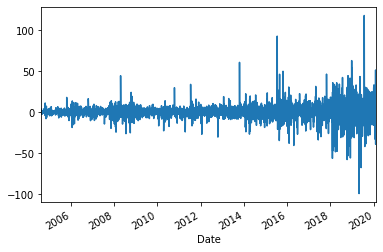

In [9]:
# as p-value >0.05, differencing
train['price_diff'] = train['price'] - train['price'].shift(1)
train['price_diff'].dropna().plot()

After performing the first differencing, despite the above plot which shows stationary, we perform ADF test again to confirm statistically

In [10]:
#ADF Test to check if time series is stationary or non-stationary after first differencing
X_1 = train['price_diff'].dropna()
result = adfuller(X_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.172376
p-value: 0.000000


Above p-value indicates that first differencing has made the data stationary. Hence the value of 1 can be used as a differencing 'd' parameter in the ARIMA model. Next step is to identify the right 'p' & 'q' values for the ARIMA model using ACF & PACH plots as shown below.

## ACF and PACF

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

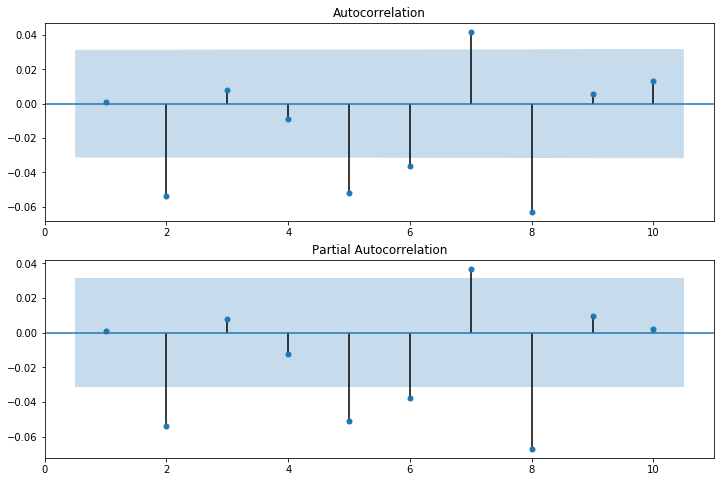

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['price_diff'].iloc[1:],lags=10, zero = False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train['price_diff'].iloc[1:],lags=10, zero = False, ax=ax2)

We take p = 2 and q =2 as with any next level of differencing, the Autocorrelation plot goes into the far negative zone fairly quickly, which indicates, the series might have been over-differenced.

## Tuning p(AR) term

In [16]:
# empty list to store aic/bic score
aic_p = []
bic_p = []

# p values
p = range(1,6) # [1,2,3,4,5]

# aic/bic score for different values of p
for i in p:
    model = ARIMA(train['price'], order=(i,1,0)) # define AR model
    model_fit = model.fit(disp=-1) # fit the model
    aic_temp = model_fit.aic # get aic score
    bic_temp = model_fit.bic # get bic score
    aic_p.append(aic_temp) # append aic score
    bic_p.append(bic_temp) # append bic score

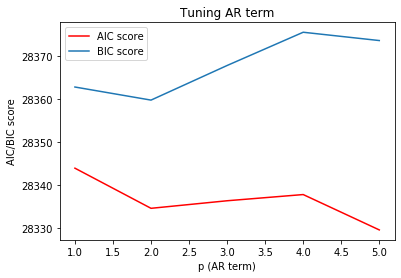

In [25]:
# Plot of AIC/BIC score for AR term
plt.plot(range(1,6),aic_p, color='red')
plt.plot(range(1,6),bic_p)
plt.title('Tuning AR term')
plt.xlabel('p (AR term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score','BIC score'])
plt.show()

In [26]:
## Tuning q(MA) term

In [27]:
# empty list to store aic/bic score
aic_q = []
bic_q = []

# q values
q = range(1,6) # [1,2,3,4,5]

# aic/bic score for different values of q
for i in q:
    model = ARIMA(train['price'], order=(0,1,i)) # define MA model
    model_fit = model.fit(disp=-1) # fit the model
    aic_temp = model_fit.aic # get aic score
    bic_temp = model_fit.bic # get bic score
    aic_q.append(aic_temp) # append aic score
    bic_q.append(bic_temp) # append bic score

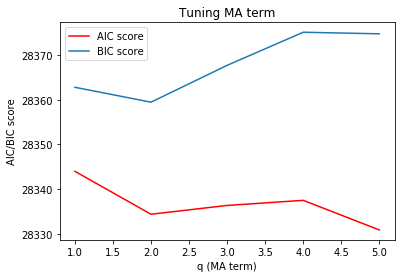

In [28]:
# Plot of AIC/BIC score for MA term
plt.plot(range(1,6),aic_q, color='red')
plt.plot(range(1,6),bic_q)
plt.title('Tuning MA term')
plt.xlabel('q (MA term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score','BIC score'])
plt.show()

## ARIMA

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 3899
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -14158.452
Method:                       css-mle   S.D. of innovations              9.137
Date:                Thu, 04 Jun 2020   AIC                          28328.905
Time:                        11:46:25   BIC                          28366.515
Sample:                             1   HQIC                         28342.254
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3755      0.119      3.149      0.002       0.142       0.609
ar.L1.D.price     0.0511      0.154      0.332      0.740      -0.250       0.352
ar.L2.D.price     0.6211      0.142     

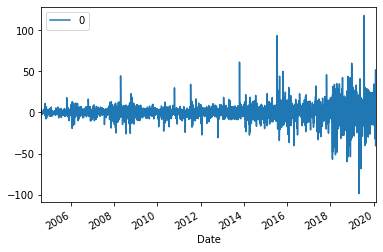

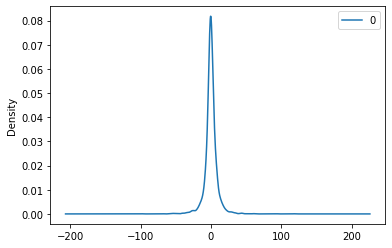

                 0
count  3899.000000
mean      0.000025
std       9.138449
min     -98.539754
25%      -3.158126
50%      -0.140759
75%       3.248041
max     117.839429


In [31]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train['price'].dropna(), order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
print(residuals.describe())
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


In [32]:
#forecast one day

forecast = model_fit.forecast()[0]
print('Forecast: %f' % forecast)

Forecast: 1520.411437


In [33]:
predictions = list()
train_data = [x for x in train['price']]
for t in range(test.shape[0]):
    model = ARIMA(train_data, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.price[t]
    train_data.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


predicted=1521.421971, expected=1519.670044
predicted=1519.691905, expected=1526.689941
predicted=1527.208144, expected=1518.150024
predicted=1518.140376, expected=1485.109985
predicted=1485.954391, expected=1421.589966
predicted=1423.083855, expected=1388.449951
predicted=1391.163313, expected=1393.180054
predicted=1394.764845, expected=1318.089966
predicted=1316.926784, expected=1339.329956
predicted=1343.219273, expected=1389.109985
predicted=1387.642762, expected=1341.390015
predicted=1340.040419, expected=1386.520020
predicted=1388.827482, expected=1319.040039
predicted=1317.328501, expected=1298.410034
predicted=1303.648516, expected=1215.560059
predicted=1214.310473, expected=1280.390015
predicted=1281.875725, expected=1215.410034
predicted=1216.631791, expected=1114.910034
predicted=1121.222310, expected=1219.729980
predicted=1212.153645, expected=1084.329956
predicted=1094.094876, expected=1119.800049
predicted=1123.212442, expected=1096.800049
predicted=1092.852568, expected=

Test MSE: 2831.322


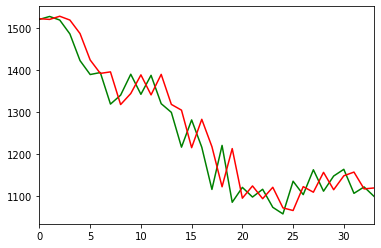

In [34]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pd.Series(np.array(test.price)).plot(kind='line', color = 'g')
pd.Series(np.concatenate( predictions, axis=0 )).plot(kind='line', color = 'r')

plt.show()

Although the direction is predicted correctly, we can implement trading strategy of buy or sell - the magnitude is not accurate which can be seen from MSE. Machine learning models can be further used to build better model
